In [66]:
import sys
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
from scipy.stats import pearsonr
from itertools import combinations

In [67]:
def get_config(file):
    """
    Read in config file and return it as a dictionary.
    
    :parameter
    ----------
    file - str
        Configuration file in yaml format

    :returns
    --------
    config - dict
        Configuration file in dictionary form.
    """
    if not file.exists():
        raise FileExistsError(f"The file that was supplied does not exists: {file}")

    with open(file, 'r') as stream:
        config = yaml.safe_load(stream)

    return config

In [68]:
config = get_config(Path("config.yaml"))

In [69]:
results_fisher = {}
methods_fisher = {}

for trait, info in config["results_fisher"].items():
    results_fisher[trait] = []
    for method, file in info.items():
        df = pd.read_csv(file, sep="\t")
        df.drop(columns=df.columns[0], inplace=True)
        results_fisher[trait].append((method, df))
        if method not in methods_fisher:
            methods_fisher[method] = {trait: df}
        else:
            methods_fisher[method][trait] = df

# Compare the result of the fisher exact tests for a variety of different HPO terms. 

In [70]:
def plot_fisher_results(fisher_results, method) -> None:
    """
    Numerous fisher exact tests were done using different HPO terms on the result on various
    gene prioritization methods.
    
    This function visualized the results of those Fisher's exact test on the different HPO terms.
    By doing so it enables the user to determine if the genes prioritized by each method, 
    are trait-specific or shared among different diseases
    
    :parameters
    -----------
    fisher_results - dict
        A dictionary containing the name of the trait as a key and the dataframe containing the results
        of the Fisher's exact tests as value.
    method- str
        Name of the gene prioritization method.
    """
    gwas_traits = {"Height": "Height", "IBD": "inflammatory bowel disease", "PrC":"prostate cancer"}
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    for i, (trait, data) in enumerate(fisher_results.items()):
        hpo_id = data.loc[data["GWAS trait"].str.lower() == gwas_traits[trait].lower(), "HPO ID"].values[0]
        trait_index = data["HPO ID"] == hpo_id
        x_hpo = data.loc[trait_index, "HPO ID"].values[0]
        y_hpo = data.loc[trait_index, "zscores"].values[0]
        g = sns.scatterplot(data = data, x="HPO ID", y="zscores", 
                        hue=trait_index, legend=False, 
                            ax=axes[i], alpha= 0.6)

        axes[i].text(x_hpo, y_hpo, x_hpo)
        axes[i].set_xticks(data["HPO ID"] ,rotation=90)
        axes[i].tick_params(labelrotation=90)
        axes[i].axhline(y=-1.65, xmin=0, xmax=1, linestyle='--', c='red')
        axes[i].set_xlabel("HPO terms", fontsize=14)
        axes[i].set_ylabel("zscores", fontsize=14)
        axes[i].set_title(f"Enrichment of {method} amongst 44 HPO terms, \ngene prioritized for {trait}", fontsize=14)
        axes[i].set_ylim(-9, 4.5)

    plt.show()

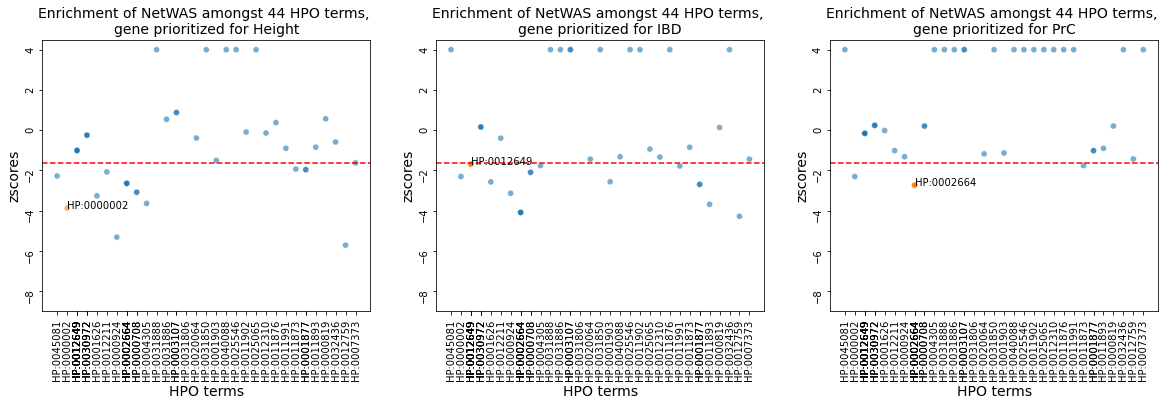

In [71]:
plot_fisher_results(methods_fisher["NetWAS"], "NetWAS")

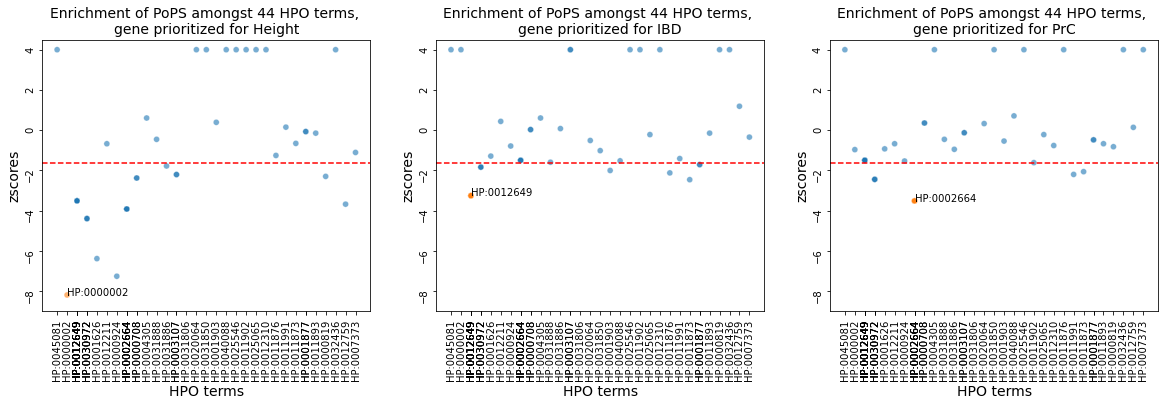

In [72]:
plot_fisher_results(methods_fisher["PoPs"], "PoPS")

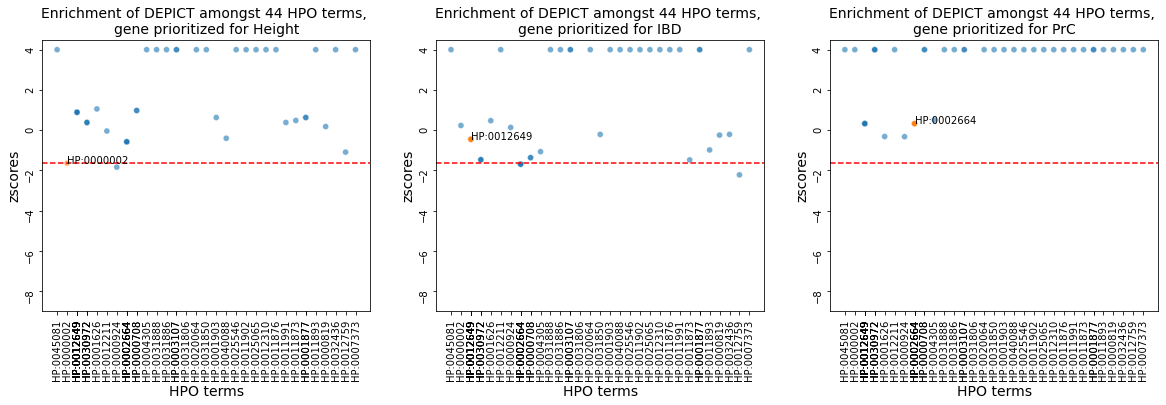

In [73]:
plot_fisher_results(methods_fisher["DEPICT"], "DEPICT")

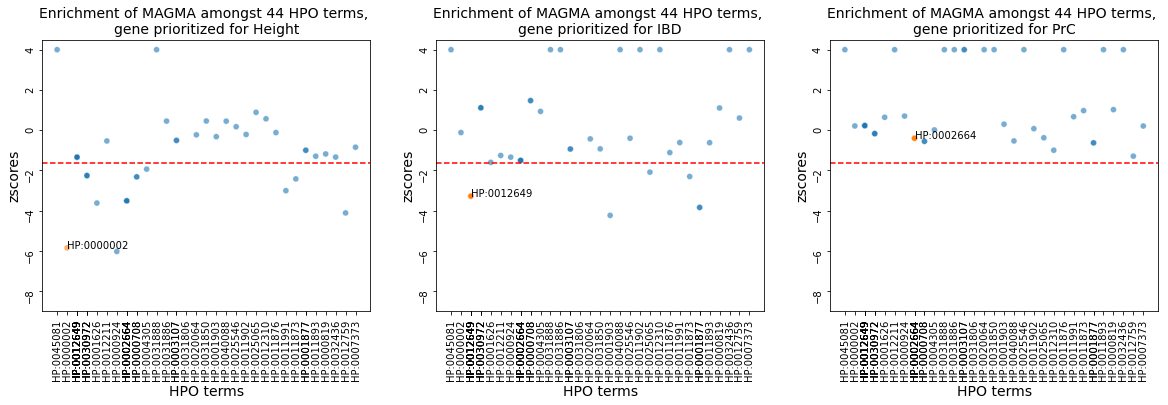

In [74]:
plot_fisher_results(methods_fisher["MAGMA"], "MAGMA")

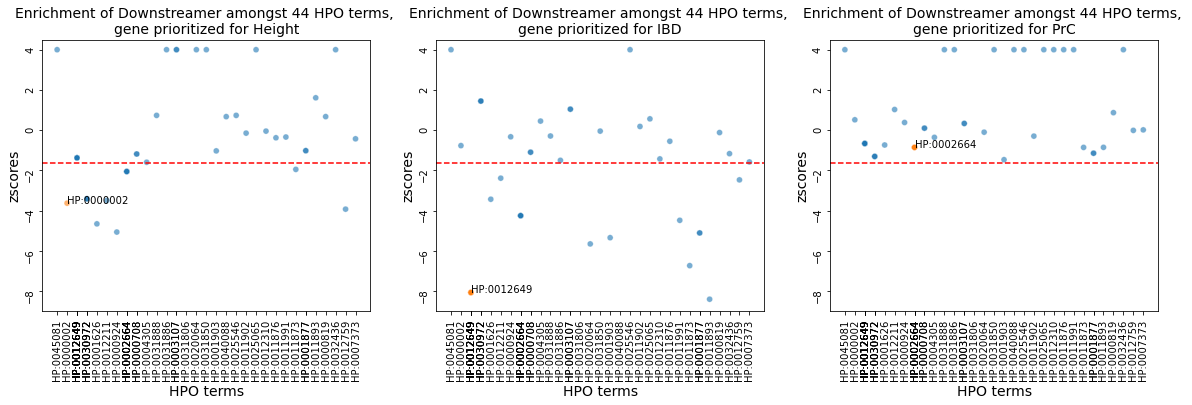

In [75]:
plot_fisher_results(methods_fisher["Downstreamer"], "Downstreamer")

# Compare the gene scores of different gene prioritization methods

Every method prioritizes a gene differently and here we would like to compare the methods in a general way by looking at what score each method gave to the same genes. 

In [76]:
HPO = config["hpo_data"]
hpo_data = pd.read_csv(HPO, compression='gzip', sep="\t")
hpo_data.set_index('-', inplace=True)
hpo_data.head(5)

,HP:0001187,HP:0009902,HP:0025152,HP:0009905,HP:0009904,HP:0001188,HP:0009907,HP:0025158,HP:0001182,HP:0009906,...,HP:0000558,HP:0001889,HP:0000553,HP:0001884,HP:0001883,HP:0000552,HP:0000555,HP:0001886,HP:0000554,HP:0001885
-,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
def read_netwas(data):
    """
    Read in data from a CSV file generated by NetWAS.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    netwas_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    netwas_data = pd.read_csv(data, sep=",")
    return netwas_data, netwas_data[["ensemble_id", "netwas_score"]]


def read_pops(data):
    """
    Read in data from a CSV file generated by PoPs.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    pops_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    pops_data = pd.read_csv(data, sep="\t")
    return pops_data, pops_data[["ENSGID", "PoPS_Score"]]


def read_downstreamer(data):
    """
    Read in data from a excel file generated by Downstreamer.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    downstreamer_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    downstreamer_data = pd.read_excel(data, "GenePrioritization")
    return downstreamer_data, downstreamer_data[["Gene ID", "Enrichment Z-score"]]

def read_magma(data):
    """
    Read in data from a CSV file generated by MAGMA.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    magma_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    magma_data = pd.read_csv(data, sep='\s\s+', engine='python')
    return magma_data, magma_data[["GENE", "ZSTAT"]]


def read_depict(data):
    """
    Read in data from a CSV file generated by DEPICT.

    :parameters
    -----------
    data - Path
        File containing the data

    :returns
    --------
    depict_data - pd.DataFrame
        Data in a data frame
    gene_scores - pd.DataFrame
        Gene IDs and scores
    """
    depict_data = pd.read_csv(data, sep="\t")
    depict_data.columns = depict_data.columns.str.rstrip()
    depict_data["Ensembl Gene ID"] = depict_data["Ensembl Gene ID"].str.rstrip()
    depict_data["zscores"] = stats.zscore(depict_data["Nominal P value"], nan_policy='omit')
    return depict_data, depict_data[["Ensembl Gene ID", "zscores"]]

In [78]:
read_data = {"NetWAS": read_netwas, "PoPs": read_pops, "MAGMA": read_magma, 
             "DEPICT": read_depict, "Downstreamer": read_downstreamer}


results_methods = {}

gene_score_methods = {}

for trait, info in config["results_methods"].items():
    results_methods[trait] = {}
    gene_score_methods[trait] = []
    for method, file in info.items():
        data, gene_scores = read_data[method](file)
        results_methods[trait][method] = {'data':data, "genes":gene_scores.iloc[:,0]}
        gene_score_methods[trait].append((method, gene_scores))

C:\Users\stijn\anaconda3\envs\DSLS_prog\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\stijn\anaconda3\envs\DSLS_prog\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\stijn\anaconda3\envs\DSLS_prog\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [79]:
def plot_score_comparison(trait_data, hpo_data, hpo_term, trait) -> None:
    """
    There are several gene prioritization method each with their own way of "prioritizing" genes.
    This function compares the 'scores' each method gave to the genes.
    
    :parameters
    -----------
    trait_data - list<tuple>
        A list with tuples containing the name of the gene prioritization method and their results
        for a specific trait (e.g. height, IBD, or prostate cancer)
    hpo_data - pd.DataFrame
        Dataframe containing the HPO data
    hpo_term - str
        Relevant HPO term for the GWAS trait that was used.
        example: GWAS trait = height, hpo term = HP:0000002 (skeletal abnormalities)
    trait - str
        Name of the GWAS trait that was originally used.
    """
    plt.figure(figsize=(20, 18))

    hpo_term_genes = hpo_data.index[hpo_data[hpo_term] == 1].values

    for i, (method1, method2) in enumerate(combinations(trait_data,2)):
        plt.subplot(4, 3, i+1)
        # Take the overlap between two methods
        overlap = method1[1].iloc[:, 0].isin(method2[1].iloc[:, 0])
        # Filter the first method based on that overlap 
        method1_overlap = method1[1].loc[overlap, :]

        # Filter the second method based on that overlap 
        method2_overlap = method2[1][method2[1].iloc[:, 0].isin(method1_overlap.iloc[:, 0])]
        hpo_genes = method2_overlap.iloc[:, 0].isin(hpo_term_genes)

        # Sort the two data frames -> same order of genes
        method1_overlap = method1_overlap.sort_values(method1_overlap.columns[0], ascending = False, inplace=False).copy()


        method2_overlap = method2_overlap.sort_values(method2_overlap.columns[0], ascending = False, inplace=False).copy()

        x = method1_overlap.loc[~hpo_genes.values].iloc[:, 1]
        x_hpo = method1_overlap.loc[hpo_genes.values].iloc[:, 1]
        
        y = method2_overlap.loc[~hpo_genes.values].iloc[:, 1]
        y_hpo = method2_overlap.loc[hpo_genes.values].iloc[:, 1]
        
        corr, _ = pearsonr(x, y)

        plt.scatter(x, y, alpha=0.5, label="Prioritized genes")
        plt.scatter(x_hpo, y_hpo, alpha=0.3, label="HPO genes")

        plt.text(plt.xlim()[0], plt.ylim()[1] ,np.round(corr, 2))
                
        # Create a regression line
        coefs = np.polyfit(x, y, deg=1)
        curvefit = np.poly1d(coefs)
        
        corr_line = plt.plot(np.unique(x), curvefit(np.unique(x)), ls="--", c=".1") 
        
        plt.xlabel(f"{method1[0]} score"); plt.ylabel(f"{method2[0]} score")
        plt.legend(loc="upper right")

    plt.show()

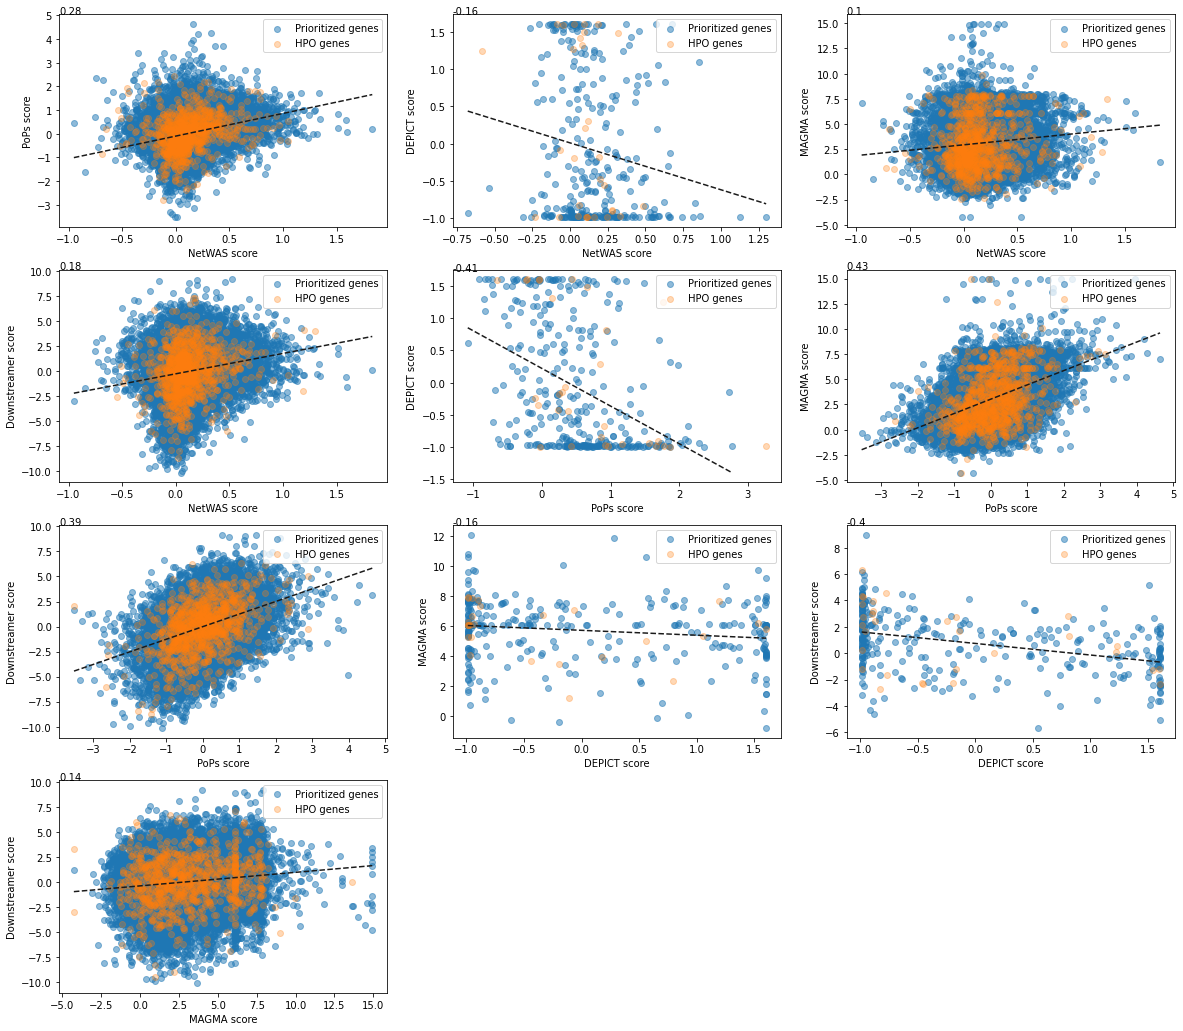

In [80]:
height_hpo = 'HP:0000002'
plot_score_comparison(trait_data=gene_score_methods["Height"], hpo_data=hpo_data, hpo_term=height_hpo, trait="Height")

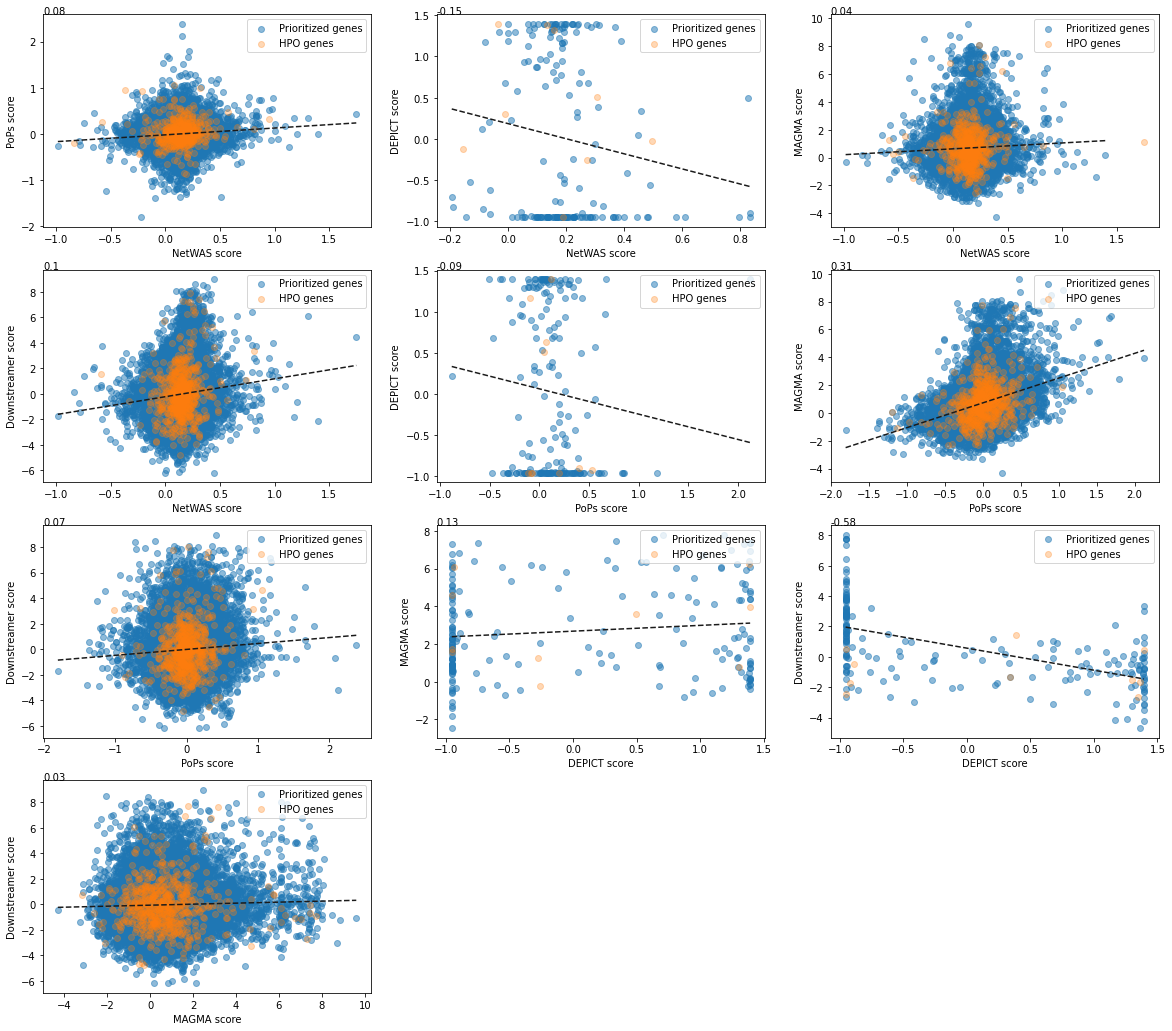

In [81]:

ibd_hpo = 'HP:0012649'
plot_score_comparison(trait_data=gene_score_methods["IBD"], hpo_data=hpo_data, hpo_term=ibd_hpo, trait="IBD")

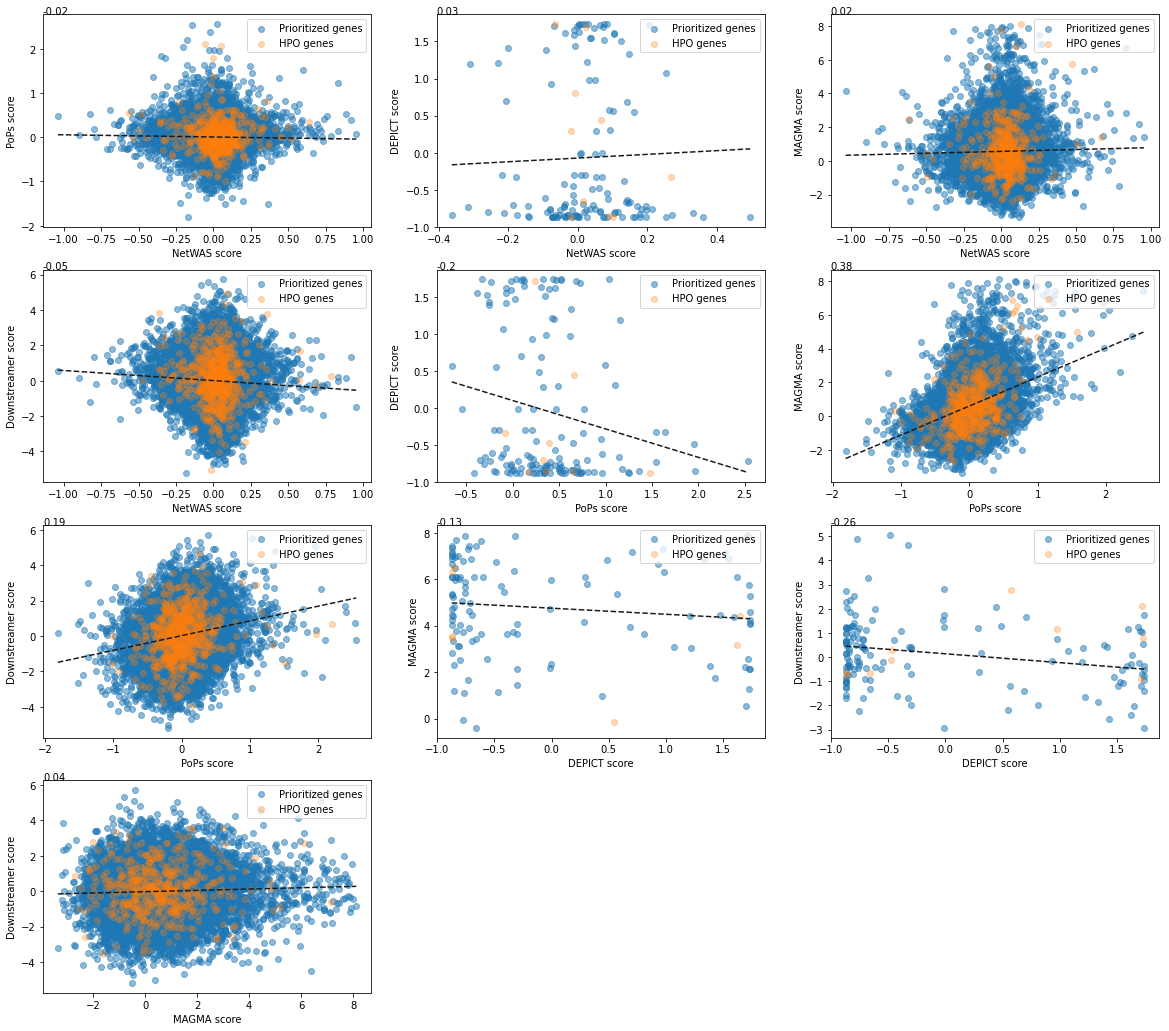

In [82]:
prc_hpo = 'HP:0002664'
plot_score_comparison(trait_data=gene_score_methods["PrC"], hpo_data=hpo_data, hpo_term=prc_hpo, trait="PrC")

# Calculate and plot the percentage of prioritized genes that overlap with a related HPO term

In [110]:
def get_overlap_hpo(hpo_data, genes):
    """
    Get the genes overlapping with the HPO database.

    :parameters
    -----------
    hpo_data - pd.DataFrame
        HPO data inside a pandas dataframe
    genes - pd.Series
        Series of gene IDs

    :returns
    --------
    overlap_hpo - pd.DataFrame
        HPO data overlapping with the supplied genes
    overlap_genes - pd.Series
        Genes overlapping with the HPO data
    """
    overlapping_genes_data = hpo_data[hpo_data.index.isin(genes)]
    overlapping_genes = overlapping_genes_data.index

    # Only keep the genes that overlap with HPO
    overlap_genes = genes[genes.isin(overlapping_genes)]

    # Only keep releveant HPO data
    overlap_hpo = hpo_data[hpo_data.index.isin(overlapping_genes)]
    return overlap_hpo, overlap_genes

In [111]:
def get_overlap_genes_netwas(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_netwas - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_netwas = data[data.ensemble_id.isin(genes)]
    return overlap_netwas, overlap_netwas["ensemble_id"]

def get_overlap_genes_pops(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_pops - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_pops = data[data["ENSGID"].isin(genes)]
    return overlap_pops, overlap_pops["ENSGID"]

def get_overlap_genes_depict(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_depict - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_depict = data[data["Ensembl Gene ID"].isin(genes)]
    return overlap_depict, overlap_depict["Ensembl Gene ID"]

def get_overlap_genes_downstreamer(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_downstreamer - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_downstreamer = data[data["Gene ID"].isin(genes)]
    return overlap_downstreamer, overlap_downstreamer["Gene ID"]

def get_overlap_genes_magma(data, genes):
    """
    Get the data that overlaps with a list of specified genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    genes - pd.Series
        List of gene IDs

    :returns
    --------
    overlap_magma - pd.DataFrame
        Data overlapping with specified genes
    """
    overlap_magma = data[data["GENE"].isin(genes)]
    return overlap_magma, overlap_magma["GENE"]

In [112]:
def filter_netwas(data, threshold=0.5):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_netwas - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_netwas = data[data.netwas_score > threshold]
    significant_genes = significant_netwas.ensemble_id
    return significant_netwas, significant_genes

def filter_pops(data, threshold=500):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_pops - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_pops = data.sort_values("PoPS_Score", ascending=False).iloc[0:threshold, :]
    significant_genes = significant_pops["ENSGID"]
    return significant_pops, significant_genes


def filter_depict(data, threshold = None):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_depict - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_depict = data[data["False discovery rate < 5%"] == "Yes"]
    significant_genes = significant_depict["Ensembl Gene ID"]
    return significant_depict, significant_genes



def filter_downstreamer(data, threshold = None):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what significant is.

    :returns
    --------
    significant_downstreamer - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_downstreamer = data[data["FDR 5% significant"] == True]
    significant_genes = significant_downstreamer["Gene ID"]
    return significant_downstreamer, significant_genes


def filter_magma(data, threshold=1.084e-4):
    """
    Filter the data by only keeping the 'significant' genes.

    :parameters
    -----------
    data - pd.DataFrame
        Data
    threshold - float
        Threshold to determine what gene is significant.

    :returns
    --------
    significant_mamga - pd.DataFrame
        Data filtered to contain only 'significant' genes
    significant_genes - pd.Series
        Gene IDs of the significant genes
    """
    significant_magma = data[data["P"] < threshold]
    significant_genes = significant_magma["GENE"]
    return significant_magma, significant_genes

In [114]:
filter_data = {"NetWAS": filter_netwas, "PoPs": filter_pops, "MAGMA": filter_magma, 
             "DEPICT": filter_depict, "Downstreamer": filter_downstreamer}

get_overlap_genes = {"NetWAS": get_overlap_genes_netwas, "PoPs": get_overlap_genes_pops, "MAGMA": get_overlap_genes_magma, 
             "DEPICT": get_overlap_genes_depict, "Downstreamer": get_overlap_genes_downstreamer}

## Calculate Recall & Precision

In [118]:
def calculate_conf_matrix(genes, sign_genes, hpo_data, hpo_term):
    """
    Best version at the moment.
    """
    total = len(genes) + len(sign_genes)
    print(f"Total P + N: {total}")
    hpo_genes = hpo_data[hpo_data[hpo_term] == 1].index
    
    n_overlap = genes.isin(hpo_genes).sum()
    print(f"Number of overlapping non significant genes: {n_overlap}")
    n_overlap_sign = sign_genes.isin(hpo_genes).sum()
    print(f"Number of overlapping significant genes: {n_overlap_sign}")
    
    # True positives: TP = prioritized gene that IS inside the HPO term gene list
    TP = n_overlap_sign
    print(f"True positive: {TP}")
    # True negatives: TN = gene not prioritized that is also NOT in the HPO term gene list
    TN = len(genes) - n_overlap
    print(f"True negative: {TN}")
    # False positives: FP = prioritized gene that is NOT inside the HPO term gene list
    FP = len(sign_genes) - n_overlap_sign
    print(f"False positive: {FP}")
    # False negatives: FN = gene not prioritized that IS inside the HPO term gene list
    FN = n_overlap
    print(f"False negative: {FN}")
    
    recall = np.round(TP / (TP + FN), 4)
    print(f"Recall: {recall} or: {recall * 100:.4}%")
    
    precision = np.round(TP / (TP + FP), 4)
    print(f"Precision: {precision} or: {precision * 100:.4}%")
    
    print("\nConfusion matrix: ")
    conf_matrix = pd.DataFrame({"TN": [TN, FP, "FP"], "FN": [FN, TP, "TP"]})
    # conf_matrix.index = ["Predicted", "Predicted"]
    print(conf_matrix.to_markdown())
    
    return recall, precision
    


In [119]:
precision_recall_methods = {"precision": [],
                           "recall": [],
                           "method": [],
                           "trait": []}

data_per_method = {}

for method, data in results_methods["Height"].items():
    print(f"\nMethod: {method}\n")
    overlap_hpo, overlap_genes_hpo = get_overlap_hpo(hpo_data, data["genes"])

    overlapping_data, overlapping_genes = get_overlap_genes[method](data["data"], overlap_genes_hpo)

    sign_data, sign_genes = filter_data[method](overlapping_data)

    if method not in data_per_method:
        data_per_method[method] = [data["data"]] # sign_data
    else:
        data_per_method[method].append(data["data"])

    percentage = calculate_percentage_overlap(sign_genes, hpo_data, height_hpo)

    negative_genes = overlapping_genes[~overlapping_genes.isin(sign_genes)]

    recall, precision = calculate_conf_matrix(negative_genes, sign_genes, hpo_data, height_hpo)
    precision_recall_methods["method"].append(method)
    precision_recall_methods["precision"].append(precision)
    precision_recall_methods["recall"].append(recall)
    precision_recall_methods["trait"].append("height")


Method: NetWAS

Total P + N: 17479
Number of overlapping non significant genes: 934
Number of overlapping significant genes: 98
True positive: 98
True negative: 15437
False positive: 1010
False negative: 934
Recall: 0.095 or: 9.5%
Precision: 0.0884 or: 8.84%

Confusion matrix: 
|    | TN    | FN   |
|---:|:------|:-----|
|  0 | 15437 | 934  |
|  1 | 1010  | 98   |
|  2 | FP    | TP   |

Method: PoPs

Total P + N: 18029
Number of overlapping non significant genes: 934
Number of overlapping significant genes: 78
True positive: 78
True negative: 16595
False positive: 422
False negative: 934
Recall: 0.0771 or: 7.71%
Precision: 0.156 or: 15.6%

Confusion matrix: 
|    | TN    | FN   |
|---:|:------|:-----|
|  0 | 16595 | 934  |
|  1 | 422   | 78   |
|  2 | FP    | TP   |

Method: DEPICT

Total P + N: 389
Number of overlapping non significant genes: 18
Number of overlapping significant genes: 13
True positive: 13
True negative: 271
False positive: 87
False negative: 18
Recall: 0.4194 or: 41

In [120]:
for method, data in results_methods["IBD"].items():
    print(f"\nMethod: {method}\n")
    
    overlap_hpo, overlap_genes_hpo = get_overlap_hpo(hpo_data, data["genes"])

    overlapping_data, overlapping_genes = get_overlap_genes[method](data["data"], overlap_genes_hpo)
    
    sign_data, sign_genes = filter_data[method](overlapping_data)
    if method not in data_per_method:
        data_per_method[method] = [data["data"]] # sign_data
    else:
        data_per_method[method].append(data["data"]) # sign_data
    percentage = calculate_percentage_overlap(sign_genes, hpo_data, ibd_hpo)
    
    negative_genes = overlapping_genes[~overlapping_genes.isin(sign_genes)]
    
    recall, precision = calculate_conf_matrix(negative_genes, sign_genes, hpo_data, ibd_hpo)
    precision_recall_methods["method"].append(method)
    precision_recall_methods["precision"].append(precision)
    precision_recall_methods["recall"].append(recall)
    precision_recall_methods["trait"].append("IBD")


Method: NetWAS

Total P + N: 17479
Number of overlapping non significant genes: 623
Number of overlapping significant genes: 12
True positive: 12
True negative: 16671
False positive: 173
False negative: 623
Recall: 0.0189 or: 1.89%
Precision: 0.0649 or: 6.49%

Confusion matrix: 
|    | TN    | FN   |
|---:|:------|:-----|
|  0 | 16671 | 623  |
|  1 | 173   | 12   |
|  2 | FP    | TP   |

Method: PoPs

Total P + N: 18029
Number of overlapping non significant genes: 622
Number of overlapping significant genes: 34
True positive: 34
True negative: 16907
False positive: 466
False negative: 622
Recall: 0.0518 or: 5.18%
Precision: 0.068 or: 6.8%

Confusion matrix: 
|    | TN    | FN   |
|---:|:------|:-----|
|  0 | 16907 | 622  |
|  1 | 466   | 34   |
|  2 | FP    | TP   |

Method: DEPICT

Total P + N: 213
Number of overlapping non significant genes: 4
Number of overlapping significant genes: 6
True positive: 6
True negative: 120
False positive: 83
False negative: 4
Recall: 0.6 or: 60.0%
Pre

In [122]:
for method, data in results_methods["PrC"].items():
    print(f"\nMethod: {method}\n")
    overlap_hpo, overlap_genes_hpo = get_overlap_hpo(hpo_data, data["genes"])

    overlapping_data, overlapping_genes = get_overlap_genes[method](data["data"], overlap_genes_hpo)
    
    sign_data, sign_genes = filter_data[method](overlapping_data)
    if method not in data_per_method:
        data_per_method[method] = [data["data"]] # sign_data
    else:
        data_per_method[method].append(data["data"]) # sign_data
    percentage = calculate_percentage_overlap(sign_genes, hpo_data, prc_hpo)

    negative_genes = overlapping_genes[~overlapping_genes.isin(sign_genes)]
    
    recall, precision = calculate_conf_matrix(negative_genes, sign_genes, hpo_data, prc_hpo)
    precision_recall_methods["method"].append(method)
    precision_recall_methods["precision"].append(precision)
    precision_recall_methods["recall"].append(recall)
    precision_recall_methods["trait"].append("PrC")



Method: NetWAS

Total P + N: 17479
Number of overlapping non significant genes: 650
Number of overlapping significant genes: 7
True positive: 7
True negative: 16777
False positive: 45
False negative: 650
Recall: 0.0107 or: 1.07%
Precision: 0.1346 or: 13.46%

Confusion matrix: 
|    | TN    | FN   |
|---:|:------|:-----|
|  0 | 16777 | 650  |
|  1 | 45    | 7    |
|  2 | FP    | TP   |

Method: PoPs

Total P + N: 18029
Number of overlapping non significant genes: 620
Number of overlapping significant genes: 35
True positive: 35
True negative: 16909
False positive: 465
False negative: 620
Recall: 0.0534 or: 5.34%
Precision: 0.07 or: 7.0%

Confusion matrix: 
|    | TN    | FN   |
|---:|:------|:-----|
|  0 | 16909 | 620  |
|  1 | 465   | 35   |
|  2 | FP    | TP   |

Method: DEPICT

Total P + N: 168
Number of overlapping non significant genes: 8
Number of overlapping significant genes: 2
True positive: 2
True negative: 137
False positive: 21
False negative: 8
Recall: 0.2 or: 20.0%
Precis

In [124]:
df_recall_precision = pd.DataFrame(precision_recall_methods)
df_recall_precision

,precision,recall,method,trait
0,0.0884,0.0950,NetWAS,height
1,0.1560,0.0771,PoPs,height
2,0.1300,0.4194,DEPICT,height
3,0.0698,0.4615,MAGMA,height
4,0.0665,0.3327,Downstreamer,height
5,0.0649,0.0189,NetWAS,IBD
6,0.0680,0.0518,PoPs,IBD
7,0.0674,0.6000,DEPICT,IBD
8,0.0645,0.0578,MAGMA,IBD
9,0.0705,0.2069,Downstreamer,IBD


In [125]:
def plot_recall_precision(df, trait, s = 100, figsize = (8, 6)) -> None:
    ax = plt.figure(figsize = figsize)
    # sns.set(font_scale=1)
    scat = sns.scatterplot(data=df, x="precision", y="recall", hue="method",
                   s=s)
#     scat.set(xlabel='Precision', ylabel='Recall',
#             title=f"Performance of gene prioritization methods for GWAS trait {trait}")

    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('Precision', fontsize=14);
    plt.ylabel('Recall', fontsize=14);
    plt.title(f"Performance of gene prioritization methods for GWAS trait {trait}", fontsize=14)
    plt.show()

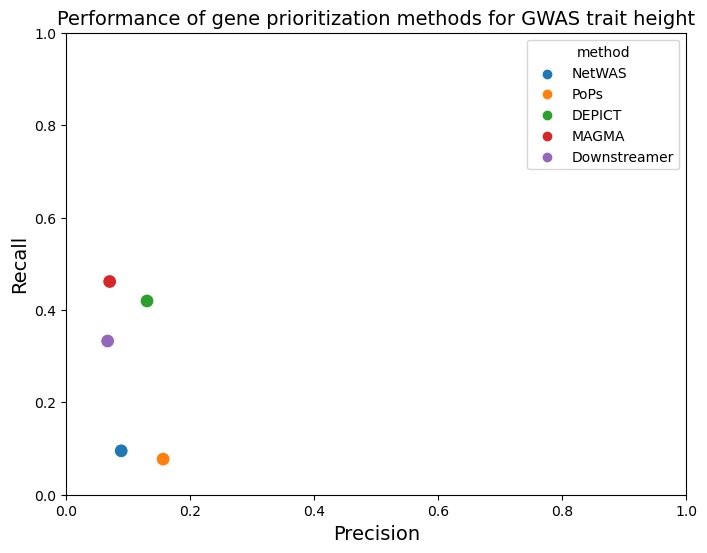

,precision,recall,method,trait
0,0.0884,0.0950,NetWAS,height
1,0.1560,0.0771,PoPs,height
2,0.1300,0.4194,DEPICT,height
3,0.0698,0.4615,MAGMA,height
4,0.0665,0.3327,Downstreamer,height


In [126]:
height_recall_precision = df_recall_precision[df_recall_precision.trait == "height"]

plot_recall_precision(height_recall_precision, "height")

height_recall_precision

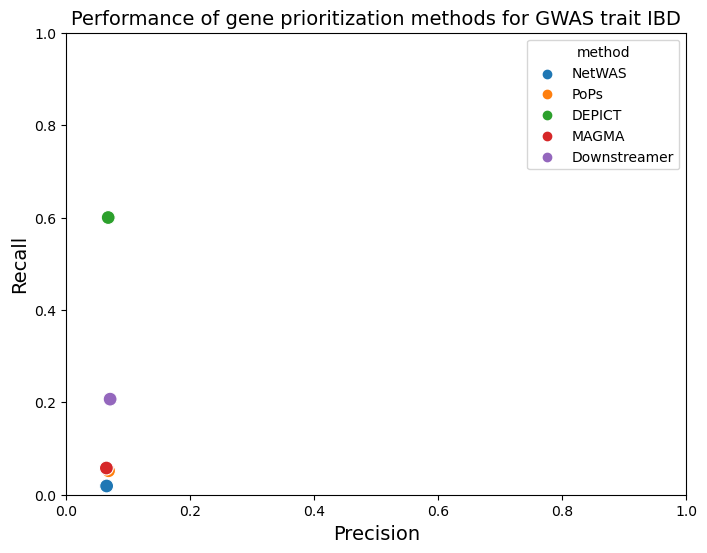

,precision,recall,method,trait
5,0.0649,0.0189,NetWAS,IBD
6,0.0680,0.0518,PoPs,IBD
7,0.0674,0.6000,DEPICT,IBD
8,0.0645,0.0578,MAGMA,IBD
9,0.0705,0.2069,Downstreamer,IBD


In [127]:
IBD_recall_precision = df_recall_precision[df_recall_precision.trait == "IBD"]

plot_recall_precision(IBD_recall_precision, "IBD")

IBD_recall_precision

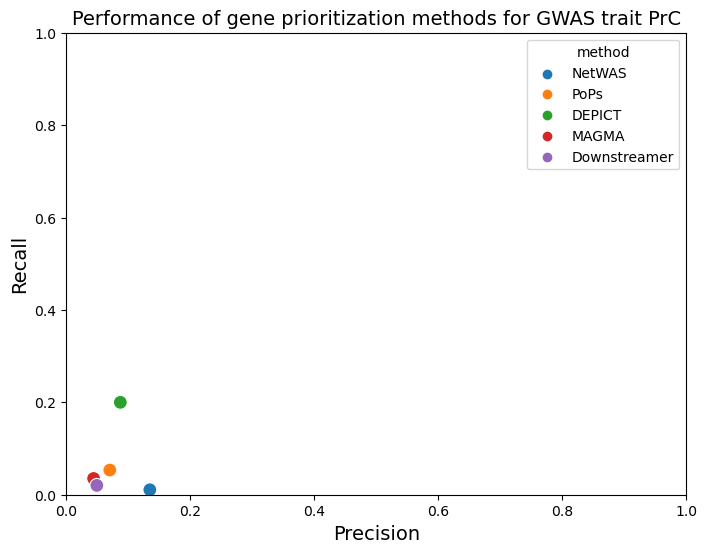

,precision,recall,method,trait
10,0.1346,0.0107,NetWAS,PrC
11,0.0700,0.0534,PoPs,PrC
12,0.0870,0.2000,DEPICT,PrC
13,0.0439,0.0352,MAGMA,PrC
14,0.0491,0.0202,Downstreamer,PrC


In [128]:
prc_recall_precision = df_recall_precision[df_recall_precision.trait == "PrC"]

plot_recall_precision(prc_recall_precision, "PrC")

prc_recall_precision